In [1]:
import os
import glob
from collections import Counter
import calendar

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import genextreme as gev
import xclim as xc
import numpy as np
import cartopy.crs as ccrs
import cmocean
from xbootstrap import block_bootstrap

from unseen import fileio
from unseen import indices

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Parameters
dpi = 300

In [3]:
# Parameters
rx15day_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_AGCD-CSIRO_r005_1900-2022_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
region_name = "east-coast-flood-region"
nino_file = "/g/data/xv83/dbi599/east-coast-rain/data/nino34-anomaly_HadISST_1870-2022_base-1981-2010.nc"

In [4]:
assert os.path.isfile(rx15day_file), "Must provide an rx15day file (papermill option -p rx15day_file [filepath])"
assert os.path.isfile(nino_file), "Must provide a Nino 3.4 file (papermill option -p nino_file [filepath])"
assert 'region_name' in locals(), "Must provide a region name (papermill option -p region_name [name])"

## Analyse and plot Rx15day data

In [5]:
ds_rx15day = fileio.open_dataset(rx15day_file)
ds_rx15day = ds_rx15day.dropna('time')

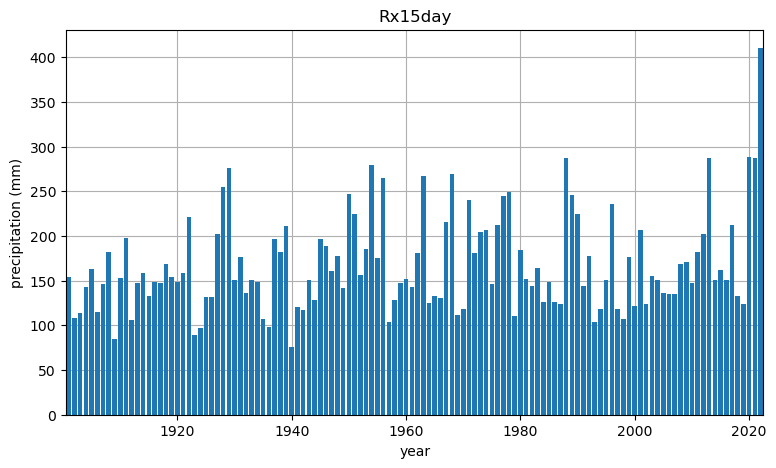

In [6]:
fig, ax = plt.subplots(figsize=[9, 5])
values = ds_rx15day['pr'].values
years = ds_rx15day['time'].dt.year.values
plt.bar(years, values, zorder=2)
plt.xlim(years[0] - 0.5, years[-1] + 0.5)
plt.title('Rx15day')
plt.ylabel('precipitation (mm)')
plt.xlabel('year')
plt.grid()
plt.savefig(
    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timeseries_AGCD_{region_name}.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=300
)
plt.show()

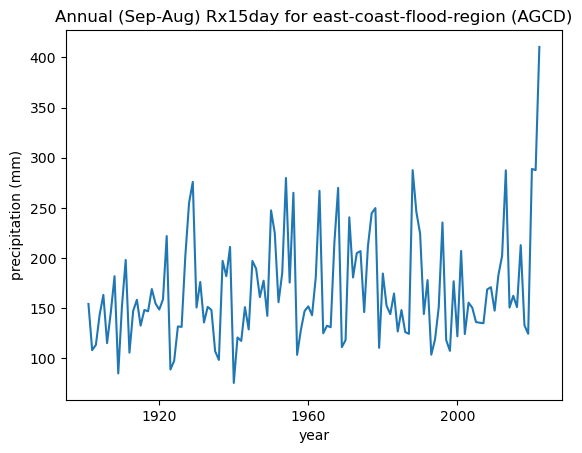

In [7]:
ds_rx15day['pr'].plot()
plt.title(f'Annual (Sep-Aug) Rx15day for {region_name} (AGCD)')
plt.ylabel('precipitation (mm)')
plt.xlabel('year')
plt.show()

In [8]:
years = ds_rx15day['time'].dt.year.values
df_rx15day = pd.DataFrame(index=years)
df_rx15day['pr'] = ds_rx15day['pr'].values
df_rx15day['event_time'] = ds_rx15day['event_time'].values

In [9]:
df_rx15day

,pr,event_time
1901,154.216827,1901-03-21
1902,108.108200,1901-09-01
1903,113.448227,1903-06-03
1904,143.368881,1904-04-07
1905,163.224609,1905-04-06
...,...,...
2018,132.922501,2018-03-07
2019,124.441978,2018-10-19
2020,288.797943,2020-02-19
2021,287.605011,2021-03-24


In [10]:
ranked_events = df_rx15day.sort_values(['pr'], ascending=False)
ranked_events.head(n=10)

,pr,event_time
2022,410.430573,2022-03-09
2020,288.797943,2020-02-19
2021,287.605011,2021-03-24
1988,287.580750,1988-04-14
2013,287.379242,2013-03-04
1954,279.746857,1954-02-23
1929,275.875671,1929-02-20
1968,269.900574,1968-01-18
1963,267.014984,1963-05-09
1956,264.992493,1956-02-20


In [11]:
rx15day_max = df_rx15day['pr'].values.max()
print(rx15day_max)

410.43057


In [12]:
event_months = [int(date[5:7]) for date in ds_rx15day['event_time'].values]
event_years = [int(date[0:4]) for date in ds_rx15day['event_time'].values]

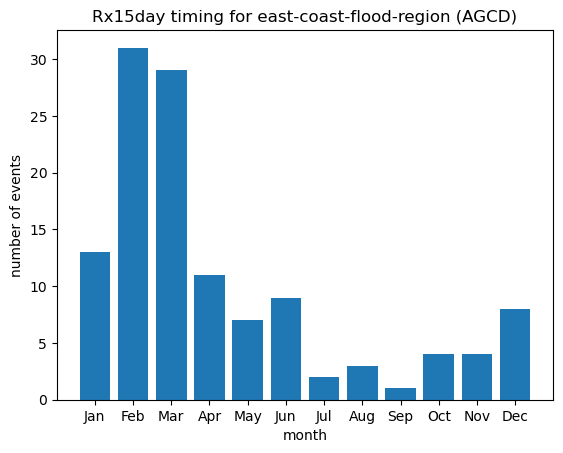

In [13]:
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f'Rx15day timing for {region_name} (AGCD)')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
plt.savefig(
    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timing_AGCD_{region_name}.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=dpi
)
plt.show()

In [14]:
nino34_ds = xr.open_dataset(nino_file)

In [15]:
event_nino34 = []
for month, year in zip(event_months, event_years):
    value = nino34_ds['sst'][(nino34_ds['time'].dt.month == month) & (nino34_ds['time'].dt.year == year)].values[0]
    event_nino34.append(value)
event_nino34 = np.array(event_nino34)

/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a fut

/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a fut

/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a fut

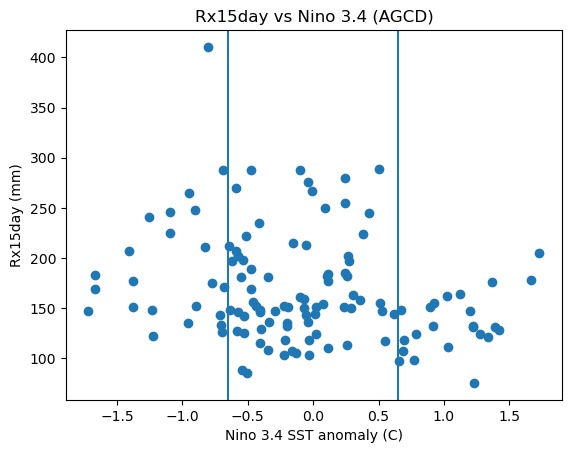

In [16]:
plt.scatter(event_nino34, ds_rx15day['pr'].values)
plt.title(f'Rx15day vs Nino 3.4 (AGCD)')
plt.ylabel('Rx15day (mm)')
plt.xlabel('Nino 3.4 SST anomaly (C)')
plt.axvline(0.65)
plt.axvline(-0.65)
plt.savefig(
    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_ENSO_AGCD_{region_name}.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=dpi
)
plt.show()

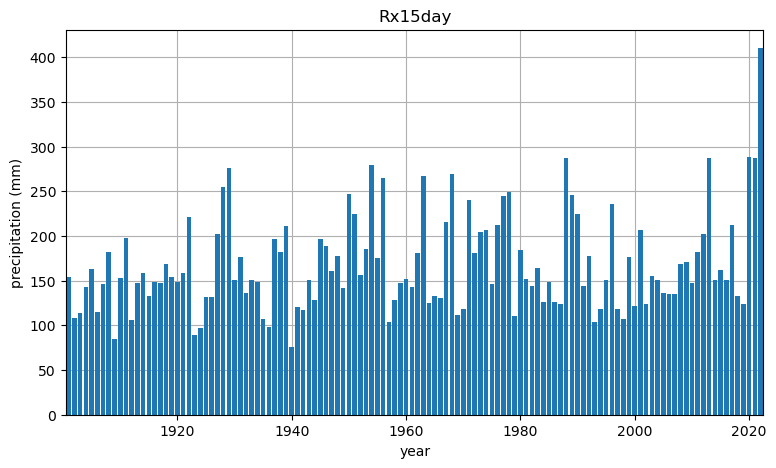

In [17]:
fig, ax = plt.subplots(figsize=[9, 5])
values = ds_rx15day['pr'].values
years = ds_rx15day['time'].dt.year.values
plt.bar(years, values, zorder=2)
plt.xlim(years[0] - 0.5, years[-1] + 0.5)
plt.title('Rx15day')
plt.ylabel('precipitation (mm)')
plt.xlabel('year')
plt.grid()
plt.savefig(
    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timeseries_AGCD_{region_name}.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=300
)
plt.show()

In [18]:
def gev_analysis(ds, event, region, savefig=False):
    """Perform GEV analysis
    
    Args:
      ds (Pandas Series): Data sample
      event (float) : Event of interest
      region (str) : Name of spatial region
    """

    gev22_shape, gev22_loc, gev22_scale = indices.fit_gev(ds.values)
    print('# Full timeseries (1900-2022)')
    print(f'Shape parameter: {gev22_shape:.2f}')
    print(f'Location parameter: {gev22_loc:.2f}')
    print(f'Scale parameter: {gev22_scale:.2f}')

    gev21_shape, gev21_loc, gev21_scale = indices.fit_gev(ds.values[:-1])
    print('# No record timeseries (1900-2021)')
    print(f'Shape parameter: {gev21_shape:.2f}')
    print(f'Location parameter: {gev21_loc:.2f}')
    print(f'Scale parameter: {gev21_scale:.2f}')
    
    fig, ax = plt.subplots(figsize=[10, 6])
    gev_xvals = np.arange(0, 700)
    ds.plot.hist(bins=40, density=True, color='tab:gray', alpha=0.5, label='Histogram')
    gev22_pdf = gev.pdf(gev_xvals, gev22_shape, gev22_loc, gev22_scale)
    plt.plot(gev_xvals, gev22_pdf, color='tab:gray', linewidth=4.0, label='GEV fit 1900-2022')
    gev21_pdf = gev.pdf(gev_xvals, gev21_shape, gev21_loc, gev21_scale)
    plt.plot(gev_xvals, gev21_pdf, color='black', linewidth=4.0, linestyle=':', label='GEV fit 1900-2021')
    plt.xlabel('precipitation (mm)')
    plt.ylabel('probability')
    plt.title(f'Annual (Sep-Aug) Rx15day for {region} (AGCD)')
    plt.xlim(0, 500)
    plt.legend()
    if savefig:
        plt.savefig(
            f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_histogram_AGCD_{region}.png',
            bbox_inches='tight',
            facecolor='white',
            dpi=300
        )
    plt.show()
    
    event22_probability = gev.sf(event, gev22_shape, loc=gev22_loc, scale=gev22_scale)
    event22_return_period = 1. / event22_probability
    event22_percentile = (1 - event22_probability) * 100
    print('# Full timeseries (1900-2022)')
    print(f'{event22_return_period:.3f} year return period')
    print(f'{event22_percentile:.2f}% percentile\n')
    
    event21_probability = gev.sf(event, gev21_shape, loc=gev21_loc, scale=gev21_scale)
    event21_return_period = 1. / event21_probability
    event21_percentile = (1 - event21_probability) * 100
    print('# No record timeseries (1900-2021)')
    print(f'{event21_return_period:.3f} year return period')
    print(f'{event21_percentile:.2f}% percentile')
    
    gev22_params = gev22_shape, gev22_loc, gev22_scale
    gev21_params = gev21_shape, gev21_loc, gev21_scale
    
    return gev22_params, gev21_params

# Full timeseries (1900-2022)
Shape parameter: -0.06
Location parameter: 142.88
Scale parameter: 39.28
# No record timeseries (1900-2021)
Shape parameter: -0.01
Location parameter: 143.11
Scale parameter: 38.74


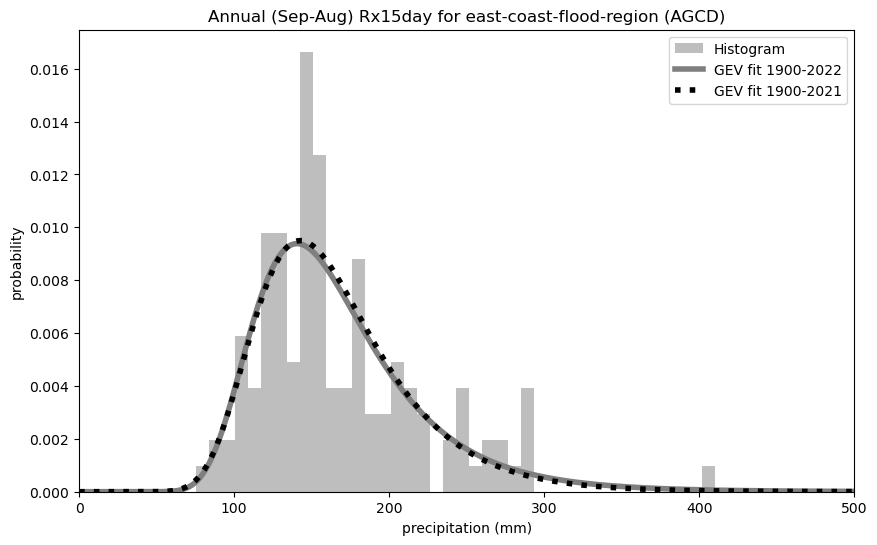

# Full timeseries (1900-2022)
296.889 year return period
99.66% percentile

# No record timeseries (1900-2021)
757.050 year return period
99.87% percentile


In [19]:
gev22_params, gev21_params = gev_analysis(df_rx15day['pr'], rx15day_max, region_name, savefig=True)

In [20]:
def return_period(data, event):
    """Get return period for given event by fitting a GEV"""
    
    shape, loc, scale = indices.fit_gev(data, generate_estimates=True)
    probability = gev.sf(event, shape, loc=loc, scale=scale)
    return_period = 1. / probability
    
    return return_period

In [21]:
def non_parametric_bootstrap_ci(da, axis, event, n_bootstraps=1000):
    """Non-parametric bootstrap to get 95% confidence interval.
    
    Axis is typically 'time' or 'sample'
    """
    da_bb = block_bootstrap(
        da.chunk({axis: -1}),
        blocks={axis: 1},
        n_iteration=n_bootstraps,
    )
    da_bb = da_bb.assign_coords({'iteration': da_bb['iteration']})
    
    bootstrap = xr.apply_ufunc(
        return_period,
        da_bb.compute(),
        input_core_dims=[[axis]],
        kwargs={'event': event},
        vectorize=True,
    )
    bootstrap_data = bootstrap.values[np.isfinite(bootstrap.values)]
    print('N samples:', len(bootstrap_data))
    lower_ci = np.quantile(bootstrap_data, 0.025)
    upper_ci = np.quantile(bootstrap_data, 0.975)
    
    return lower_ci, upper_ci

In [23]:
non_parametric_bootstrap_ci(ds_rx15day['pr'], 'time', rx15day_max, n_bootstraps=10000)

/jobfs/96349851.gadi-pbs/ipykernel_413990/381546623.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return_period = 1. / probability


N samples: 9991


(84.69904296629487, 6280.967626179457)

In [24]:
non_parametric_bootstrap_ci(ds_rx15day['pr'][:-1], 'time', rx15day_max, n_bootstraps=10000)

/jobfs/96349851.gadi-pbs/ipykernel_413990/381546623.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return_period = 1. / probability
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


N samples: 9978


(157.77817076999668, 25691.196839292268)

In [25]:
rx15day_max

410.43057

In [23]:
def parametric_bootstrap_ci(shape, loc, scale, event, sample_size, n_bootstraps=1000):
    """Parametric bootstrap to get 95% confidence interval."""
    
    estimates = []
    for i in range(n_bootstraps):
        data = gev.rvs(shape, loc=loc, scale=scale, size=sample_size)
        estimate = return_period(data, event)
        estimates.append(estimate)
    estimates = np.array(estimates)
    estimates = estimates[np.isfinite(estimates)]
    print('N samples:', len(estimates))
    lower_ci = np.quantile(estimates, 0.025)
    upper_ci = np.quantile(estimates, 0.975)
    
    return lower_ci, upper_ci

In [27]:
gev22_shape, gev22_loc, gev22_scale = gev22_params
parametric_bootstrap_ci(gev22_shape, gev22_loc, gev22_scale, rx15day_max, len(ds_rx15day['pr']), n_bootstraps=10000)

/jobfs/96349851.gadi-pbs/ipykernel_413990/381546623.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return_period = 1. / probability


N samples: 9979


(81.78567999294353, 15429.954909349282)

In [24]:
gev21_shape, gev21_loc, gev21_scale = gev21_params
parametric_bootstrap_ci(gev21_shape, gev21_loc, gev21_scale, rx15day_max, len(ds_rx15day['pr']), n_bootstraps=10000)

/jobfs/96418182.gadi-pbs/ipykernel_2443401/381546623.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return_period = 1. / probability
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


N samples: 9863


(134.85095957204382, 814214.7634637111)

In [25]:
def gev_return_curve(data, event_value, bootstrap_method='parametric', n_bootstraps=1000):
    """Return x and y data for a GEV return period curve.

    Parameters
    ----------
    data : xarray DataArray
    params : list, default None
        shape, location and scale parameters (calculated if None)
    """

    # GEV fit to data
    shape, loc, scale = indices.fit_gev(data, generate_estimates=True)
    
    curve_return_periods = np.logspace(0, 4.3, num=10000)
    curve_probabilities = 1.0 / curve_return_periods
    curve_values = gev.isf(curve_probabilities, shape, loc, scale)
    
    event_probability = gev.sf(event_value, shape, loc=loc, scale=scale)
    event_return_period = 1. / event_probability
    
    # Bootstrapping for confidence interval
    boot_values = curve_values
    boot_event_return_periods = []
    for i in range(n_bootstraps):
        if bootstrap_method == 'parametric':
            boot_data = gev.rvs(shape, loc=loc, scale=scale, size=len(data))
        elif bootstrap_method == 'non-parametric':
            boot_data = np.random.choice(data, size=data.shape, replace=True)
        boot_shape, boot_loc, boot_scale = indices.fit_gev(boot_data, generate_estimates=True)

        boot_value = gev.isf(curve_probabilities, boot_shape, boot_loc, boot_scale)
        boot_values = np.vstack((boot_values, boot_value))
        
        boot_event_probability = gev.sf(event_value, boot_shape, loc=boot_loc, scale=boot_scale)
        boot_event_return_period = 1. / boot_event_probability
        boot_event_return_periods.append(boot_event_return_period)

    curve_values_lower_ci = np.quantile(boot_values, 0.025, axis=0)
    curve_values_upper_ci = np.quantile(boot_values, 0.975, axis=0)
    curve_data = curve_return_periods, curve_values, curve_values_lower_ci, curve_values_upper_ci
    
    boot_event_return_periods = np.array(boot_event_return_periods)
    boot_event_return_periods = boot_event_return_periods[np.isfinite(boot_event_return_periods)]
    event_return_period_lower_ci = np.quantile(boot_event_return_periods, 0.025)
    event_return_period_upper_ci = np.quantile(boot_event_return_periods, 0.975)
    event_data = event_return_period, event_return_period_lower_ci, event_return_period_upper_ci
    
    return curve_data, event_data

In [26]:
def plot_return(ax, data, event_value, bootstrap_method='parametric', n_bootstraps=1000):
    """Plot a single return period curve.

    Parameters
    ----------
    data : xarray DataArray
    """

    curve_data, event_data = gev_return_curve(
        data,
        event_value,
        bootstrap_method=bootstrap_method,
        n_bootstraps=n_bootstraps,
    )
    curve_return_periods, curve_values, curve_values_lower_ci, curve_values_upper_ci = curve_data
    event_return_period, event_return_period_lower_ci, event_return_period_upper_ci = event_data
    
    ax.plot(curve_return_periods, curve_values, color='tab:blue')
    ax.fill_between(
        curve_return_periods,
        curve_values_lower_ci,
        curve_values_upper_ci,
        color='tab:blue',
        alpha=0.2
    )
    ax.plot(
        [event_return_period_lower_ci, event_return_period_upper_ci],
        [event_value] * 2,
        color='0.5',
        marker='|',
        linestyle=':'
    )
    print(f'{event_return_period:.0f} year return period')
    print(f'95% CI: {event_return_period_lower_ci:.0f}-{event_return_period_upper_ci:.0f} years')
    empirical_return_values = np.sort(data, axis=None)[::-1]
    empirical_return_periods = len(data) / np.arange(1.0, len(data) + 1.0)
    ax.scatter(empirical_return_periods, empirical_return_values, color='tab:blue', alpha=0.5)
    
    ax.set_xscale("log")
    ax.set_xlabel("return period (years)")
    ax.set_ylabel("Rx15day (mm)")
    ylim = ax.get_ylim()
    ax.set_ylim([50, ylim[-1]])
    ax.grid()

/jobfs/96418182.gadi-pbs/ipykernel_2443401/1647012747.py:35: RuntimeWarning: divide by zero encountered in double_scalars
  boot_event_return_period = 1. / boot_event_probability
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


297 year return period
95% CI: 81-15251 years


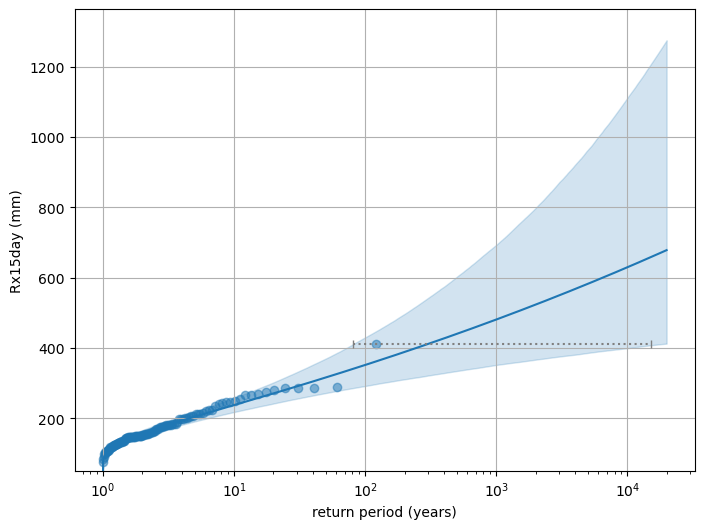

In [27]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()
plot_return(ax, ds_rx15day['pr'], rx15day_max, bootstrap_method='parametric', n_bootstraps=10000)
plt.show()

/jobfs/96418182.gadi-pbs/ipykernel_2443401/1647012747.py:35: RuntimeWarning: divide by zero encountered in double_scalars
  boot_event_return_period = 1. / boot_event_probability


297 year return period
95% CI: 87-7096 years


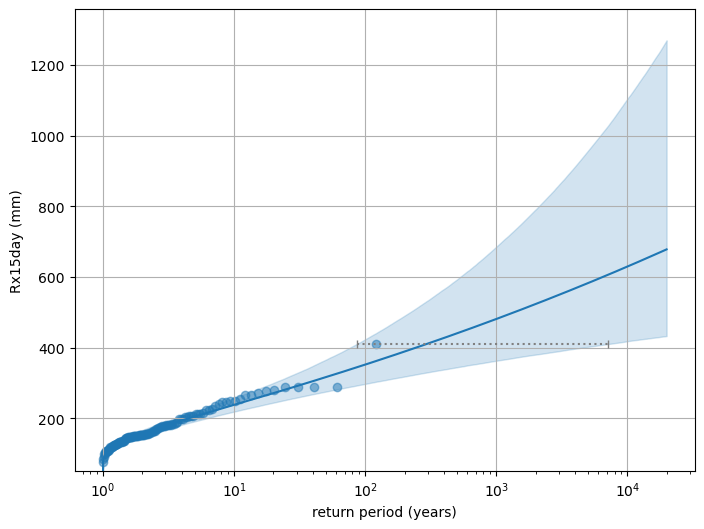

In [28]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()
plot_return(ax, ds_rx15day['pr'], rx15day_max, bootstrap_method='non-parametric', n_bootstraps=10000)
plt.show()

/jobfs/96418182.gadi-pbs/ipykernel_2443401/1647012747.py:35: RuntimeWarning: divide by zero encountered in double_scalars
  boot_event_return_period = 1. / boot_event_probability


297 year return period
95% CI: 88-7991 years


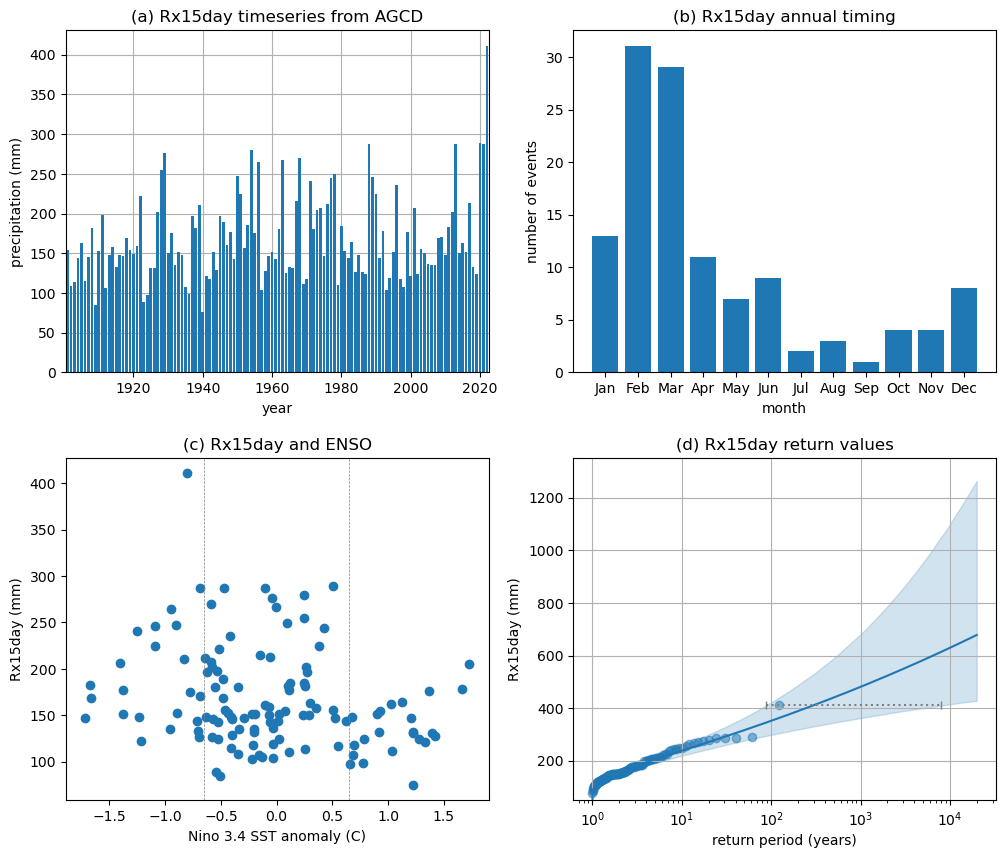

In [29]:
plt.figure(figsize=[12, 10])
gs = GridSpec(2, 2, hspace=0.25) #height_ratios=[3, 2])
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 0])
ax4 = plt.subplot(gs[1, 1])

values = ds_rx15day['pr'].values
years = ds_rx15day['time'].dt.year.values
ax1.bar(years, values, zorder=2)
ax1.set_xlim(years[0] - 0.5, years[-1] + 0.5)
ax1.set_title('(a) Rx15day timeseries from AGCD')
ax1.set_ylabel('precipitation (mm)')
ax1.set_xlabel('year')
ax1.grid()

ax2.bar(months, counts)
ax2.set_title(f'(b) Rx15day annual timing')
ax2.set_ylabel('number of events')
ax2.set_xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
ax2.set_xticks(months, xlabels)

ax3.scatter(event_nino34, ds_rx15day['pr'].values)
ax3.set_title('(c) Rx15day and ENSO')
ax3.set_ylabel('Rx15day (mm)')
ax3.set_xlabel('Nino 3.4 SST anomaly (C)')
ax3.axvline(0.65, color='0.5', linestyle='--', linewidth=0.5)
ax3.axvline(-0.65, color='0.5', linestyle='--', linewidth=0.5)

plot_return(ax4, ds_rx15day['pr'], rx15day_max, bootstrap_method='non-parametric', n_bootstraps=10000)
ax4.set_title('(d) Rx15day return values')

plt.savefig(
    '/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_AGCD_summary.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=300,
)
plt.show()

## Meteorology of the most extreme events

### 15-day aggregates

In [ ]:
def plot_average(color_da, color_var, contour_da, contour_var, start_date, end_date):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var == 'pr':
        levels = [0, 100, 200, 300, 400, 500, 600, 700, 800]
        label = 'total precipitation (mm)'
        cmap = cmocean.cm.rain
        extend = 'max'
    elif color_var == 'ua300':
        levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
        label = '300hPa zonal wind'
        cmap='RdBu_r'
        extend = 'both'
    else:
        raise ValueError('Invalid color variable')
    color_da.plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend=extend,
        cbar_kwargs={'label': label},
    )
    
    if contour_var == 'z500':
        levels = np.arange(5000, 6300, 50)
    elif contour_var == 'psl':
        levels = np.arange(900, 1100, 2.5)
    elif contour_var == 'ua300':
        levels = np.arange(15, 60, 5)
    else:
        raise ValueError('Invalid contour variable')
    lines = contour_da.plot.contour(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        levels=levels,
        colors=['0.1']
    )
    ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    ax1.gridlines(linestyle='--', draw_labels=True)
    ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
    #plt.savefig(
    #    f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
    #    bbox_inches='tight',
    #    facecolor='white',
    #    dpi=300
    #)
    plt.show()

In [ ]:
z500_files = glob.glob('/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/zg500/zg500_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_*.nc')
z500_files.sort()

pr_files = glob.glob('/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/pr/pr_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_*.nc')
pr_files.sort()

psl_files = glob.glob('/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/psl/psl_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_*.nc')
psl_files.sort()

ua300_files = glob.glob('/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/ua300/ua300_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_*.nc')
ua300_files.sort()

In [ ]:
z500_ds = xr.open_mfdataset(z500_files)
pr_ds = xr.open_mfdataset(pr_files)
psl_ds = xr.open_mfdataset(psl_files)
ua300_ds = xr.open_mfdataset(ua300_files)

In [ ]:
for index, row in ranked_events.head(n=5).iterrows():
    end_date = row['event_time']
    if int(end_date[0:4]) > 2007:
        rx_value = row['pr']
        print(f'{index} ({end_date}): {rx_value}mm')
        start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
        start_date = start_datetime.strftime("%Y-%m-%d")
        z500_da = z500_ds.sel({'time': slice(start_date, end_date)})['zg500']
        pr_da = pr_ds.sel({'time': slice(start_date, end_date)})['pr']
        pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
        psl_da = psl_ds.sel({'time': slice(start_date, end_date)})['psl']
        psl_da = xc.units.convert_units_to(psl_da, 'hPa')
        ua300_da = ua300_ds.sel({'time': slice(start_date, end_date)})['ua300']

        z500_da_mean = z500_da.mean('time', keep_attrs=True)
        pr_da_sum = pr_da.sum('time', keep_attrs=True)
        psl_da_mean = psl_da.mean('time', keep_attrs=True)
        ua300_da_mean = ua300_da.mean('time', keep_attrs=True)    

        plot_average(pr_da_sum, 'pr', z500_da_mean, 'z500', start_date, end_date)
        plot_average(pr_da_sum, 'pr', psl_da_mean, 'psl', start_date, end_date)
        plot_average(ua300_da_mean, 'ua300', z500_da_mean, 'z500', start_date, end_date)

### Day-by-day

In [ ]:
def plot_days(contour_var, start_date, end_date):
    """Plot days"""

    pr_da = pr_ds.sel({'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    
    if contour_var == 'z500':
        contour_da = z500_ds.sel({'time': slice(start_date, end_date)})['zg500']
    elif contour_var == 'psl':
        contour_da = psl_ds.sel({'time': slice(start_date, end_date)})['psl']
        contour_da = xc.units.convert_units_to(contour_da, 'hPa')
    else:
        raise ValueError('Invalid contour variable')
    
    fig = plt.figure(figsize=[20, 18])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    
    if contour_var == 'z500':
        levels = np.arange(5000, 6300, 75)
    elif contour_var == 'psl':
        levels = np.arange(900, 1100, 5)

    plot_order = [1, 4, 7, 10, 13, 2, 5, 8, 11, 14, 3, 6, 9, 12, 15]
    for day in range(15):
        ax = fig.add_subplot(5, 3, plot_order[day], projection=map_proj)
        pr_da.isel({'time': day}).plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmocean.cm.rain,
            levels=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            extend='max',
            cbar_kwargs={'label': 'total precipitation (mm)'},
        )
    
        lines = contour_da.isel({'time': day}).plot.contour(
            ax=ax,
            transform=ccrs.PlateCarree(),
            levels=levels,
            colors=['0.1']
        )
        ax.clabel(lines, colors=['0.1'], manual=False, inline=True)
        ax.coastlines()
        ax.gridlines(linestyle='--', draw_labels=True)
        date = str(pr_da.isel({'time': day})['time'].dt.strftime('%d %b').values)
        ax.set_title(date)
        ax.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    plt.suptitle(f'Daily {contour_var} ({contour_da.units})')
#    plt.savefig(
#        f'{contour_var}_days_BARRA2_{start_date}_{end_date}.png',
#        bbox_inches='tight',
#        facecolor='white',
#        dpi=300
#    )
    plt.show()

In [ ]:
plot_days('z500', '2022-02-23', '2022-03-09')

In [ ]:
plot_days('psl', '2022-02-23', '2022-03-09')